# **Neural Network from Scratch for MNIST Digit Dataset**

## **Dependencies**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from datetime import timedelta
from charminal import *

## **Read The Training Data**

In [3]:
# Read the data
data = pd.read_csv('data/train.csv')

## **Data Overview**

### **See The Data**

In [4]:
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We can see that the data is in the shape of `(n_samples, pixels)`. Since the image is in `(28 x 28)`, then the number of pixels is `784` pixels, and hence we will have `1 + 784 = 785` columns, where the first column represents the labels.

### **Check If The Data is Already Normalized**

In [5]:
# Check if the data is already normalized
pixel_min = data.iloc[:, 1:].min().min() # Select all rows, and all columns except the first column
pixel_max = data.iloc[:, 1:].max().max()
print(f'Max: {pixel_max}')
print(f'min: {pixel_min}')

# +======== OUTPUT ========+
# Max: 255
# min: 0

# Then we can see that the data isn't normalized yet

Max: 255
min: 0


We can see that the data isn't already normalized. Note that we <ins>only need to normalize the `X` (pixel values), and not the `Y` (labels)</ins>.

### **See The Shape and Randomize The Data**

In [6]:
data = np.array(data)
# data = data / 255.0 # This is WRONG! since this also normalizes the Y (label)
m, n = data.shape
np.random.shuffle(data)

print(f'data.shape (m, n): {data.shape}')
print(f'm, n: {m}, {n}')

# +=========== Output ===========+
# data.shape (m, n): (42000, 785)
# m, n: 42000, 785

# We can see that there are 42000 rows and 785 columns

data.shape (m, n): (42000, 785)
m, n: 42000, 785


## **Split The Data into Train and Validation Data**

In [7]:
# Only take the first 1000 data, and then transpose it
# The shape will be from (1000, 785) to (785, 1000)
data_val = data[0:1000].T
print(f'data_val.shape after T: {data_val.shape}')

# Notice that the shape is (m, n) = (42000, 785)
# The n is 785 since it holds 784 pixels + 1 label
# The label is located on the first row
Y_val = data_val[0, :] # The label is on the 1st row
X_val = data_val[1:n, :] # Take the remaining data (from 1:n)
X_val = X_val / 255.0

print(f'Y_val.shape: {Y_val.shape}')
print(f'X_val.shape: {X_val.shape}')

data_val.shape after T: (785, 1000)
Y_val.shape: (1000,)
X_val.shape: (784, 1000)


In [8]:
# Take the remaining data, from 1000:m, and then transpose it
# The shape will be from (42000-1000, 785) to (785, 42000-1000)
data_train = data[1000:m].T
Y_train = data_train[0]
X_train = data_train[1:n]
X_train = X_train / 255.0

print(f'Y_train.shape: {Y_train.shape}')
print(f'X_train.shape: {X_train.shape}')

Y_train.shape: (41000,)
X_train.shape: (784, 41000)


## **Helper Functions**

In [9]:
def init_params():
    """
    Function to initialize the parameters with random values from [-0.5, 0.5]
    - W: Weights
    - b: Bias
    - 1: Hidden layer
    - 2. Output layer
    """
    # Initialize with the weights ranging from [-0.5, 0.5]
    W1 = np.random.rand(20, 784) - 0.5
    b1 = np.random.rand(20, 1) - 0.5
    W2 = np.random.rand(10, 20) - 0.5
    b2 = np.random.rand(10, 1) - 0.5
    
    return W1, b1, W2, b2

def ReLU(Z):
    """
    Function to calculate the ReLU of a linear combination of weights and biases
    """
    return np.maximum(0, Z)

def softmax(Z):
    """
    Function to calculate the Softmax of a linear combination of weights and biases
    """
    return np.exp(Z) / np.sum(np.exp(Z))

def softmax_custom(Z):
    Z_exp = np.exp(Z - np.max(Z, axis=0, keepdims=True))
    
    return Z_exp / np.sum(Z_exp, axis=0, keepdims=True)

def one_hot(Y):
    """
    Function to one-hot-encode the label
    """
    one_hot_Y = np.zeros((Y.size, 10))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    
    return one_hot_Y

def deriv_ReLU(Z):
    """
    Function to calculate the derivative of ReLU activation function
    """
    return Z > 0

def forward_prop(W1, b1, W2, b2, X):
    """
    Z === pre_h: Calculation of weights + bias
    A: ActvFn(Z)
    """
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
#     A2 = softmax(Z2)
    A2 = softmax_custom(Z2)
    
    return Z1, A1, Z2, A2
    
def backward_prop(Z1, A1, Z2, A2, W2, X, Y):
    m = Y.size
    
    one_hot_Y = one_hot(Y)
    
    dZ2 = A2 - one_hot_Y
    dW2 = 1/m * dZ2.dot(A1.T)
    db2 = 1/m * np.sum(dZ2, axis=1, keepdims=True)
    
    dZ1 = W2.T.dot(dZ2) * deriv_ReLU(Z1)
    dW1 = 1/m * dZ1.dot(X.T)
    db1 = 1/m * np.sum(dZ1, axis=1, keepdims=True)
    
    return dW1, db1, dW2, db2

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate):
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    
    return W1, b1, W2, b2

def get_predictions(A2):
    return np.argmax(A2, axis=0)

def get_accuracy(predictions, Y):
#     print(predictions, Y)
    return np.sum(predictions == Y) / Y.size

## **Function to Start The Training**

In [10]:
def gradient_descent(X, Y, epochs, learning_rate):
    # Initialize paramaters
    W1, b1, W2, b2 = init_params()
    
    accuracy_dict = dict()
    
    start_time = time.time()
    for epoch in range(epochs):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W2, X, Y)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate)
        
        if epoch % 10 == 0:
            print(f'{EMOJI_CHECKPOINT} Epoch: {epoch}')
            print(f'{EMOJI_CHART} Accuracy: {get_accuracy(get_predictions(A2), Y)}')
            print(f'{EMOJI_TIME} Time: {timedelta(seconds=time.time() - start_time)}')
            
            accuracy_dict[epoch] = get_accuracy(get_predictions(A2), Y)
            
    return W1, b1, W2, b2, accuracy_dict

## **Start The Training Process**

In [18]:
start_time = time.time()
W1, b1, W2, b2, accuracy_dict = gradient_descent(X_train, Y_train, 500, 0.1)

🚩 Epoch: 0
📊 Accuracy: 0.073
⌛ Time: 0:00:00.051313
🚩 Epoch: 10
📊 Accuracy: 0.2131219512195122
⌛ Time: 0:00:00.451871
🚩 Epoch: 20
📊 Accuracy: 0.31290243902439024
⌛ Time: 0:00:00.865812
🚩 Epoch: 30
📊 Accuracy: 0.38439024390243903
⌛ Time: 0:00:01.266216
🚩 Epoch: 40
📊 Accuracy: 0.44126829268292683
⌛ Time: 0:00:01.640693
🚩 Epoch: 50
📊 Accuracy: 0.49521951219512195
⌛ Time: 0:00:02.010720
🚩 Epoch: 60
📊 Accuracy: 0.5469024390243903
⌛ Time: 0:00:02.436224
🚩 Epoch: 70
📊 Accuracy: 0.5917560975609756
⌛ Time: 0:00:02.852873
🚩 Epoch: 80
📊 Accuracy: 0.6256341463414634
⌛ Time: 0:00:03.260418
🚩 Epoch: 90
📊 Accuracy: 0.6530975609756098
⌛ Time: 0:00:03.660958
🚩 Epoch: 100
📊 Accuracy: 0.6745365853658537
⌛ Time: 0:00:04.066039
🚩 Epoch: 110
📊 Accuracy: 0.6925853658536585
⌛ Time: 0:00:04.481314
🚩 Epoch: 120
📊 Accuracy: 0.7071951219512195
⌛ Time: 0:00:04.901473
🚩 Epoch: 130
📊 Accuracy: 0.7204878048780488
⌛ Time: 0:00:05.294971
🚩 Epoch: 140
📊 Accuracy: 0.7317317073170732
⌛ Time: 0:00:05.698329
🚩 Epoch: 150
📊 

In [24]:
print(f'{COLOR_GREEN}{EMOJI_FINISH * 5} TRAINING FINISHED {EMOJI_FINISH * 5}{RESET}')
print(f'{EMOJI_TIME} Full training time: {timedelta(seconds=time.time() - start_time)}')
print(f'{EMOJI_CHART} Latest accuracy: {list(accuracy_dict.values())[-1]}')

🏁🏁🏁🏁🏁 TRAINING FINISHED 🏁🏁🏁🏁🏁
⌛ Full training time: 0:02:31.886364
📊 Latest accuracy: 0.8612439024390244


## **Functions for Predictions**

In [12]:
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    
    return predictions

def test_prediction(X_train, Y_train, index, W1, b1, W2, b2):
    current_image = X_train[:, index, None]
    prediction = make_predictions(current_image, W1, b1, W2, b2)
    label = Y_train[index]
    
    print(f'Prediction: {prediction}')
    print(f'Label: {label}')
    
    current_image = current_image.reshape((28, 28)) * 255
    
    # plt.gray()
    # plt.imshow(current_image, interpolation='nearest')
    # plt.show()

    plt.imshow(current_image, cmap='gray')
    plt.show()

## **Test The Training Result**

### **See The Predictions**

Prediction: [9]
Label: 4


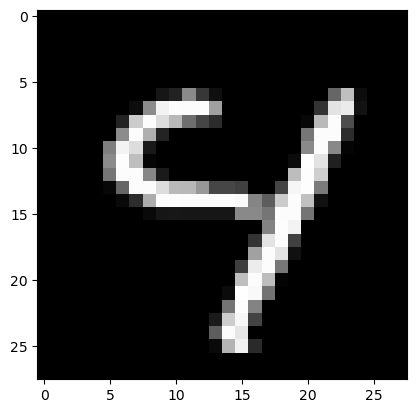

Prediction: [3]
Label: 3


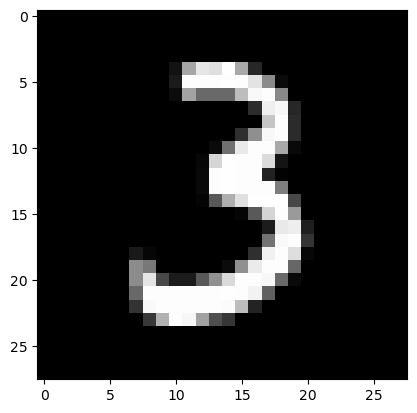

Prediction: [7]
Label: 0


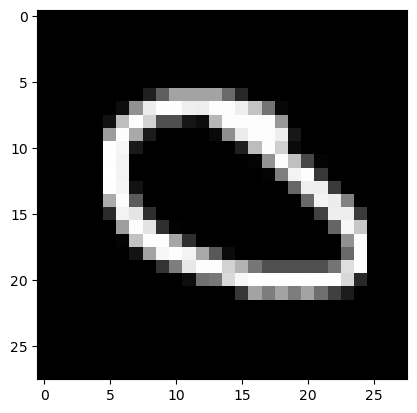

Prediction: [7]
Label: 7


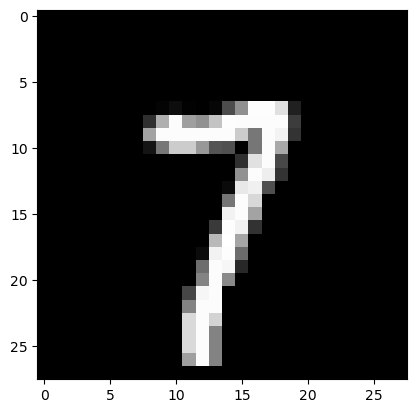

Prediction: [6]
Label: 6


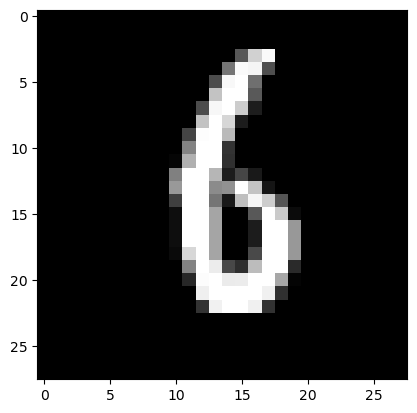

Prediction: [7]
Label: 7


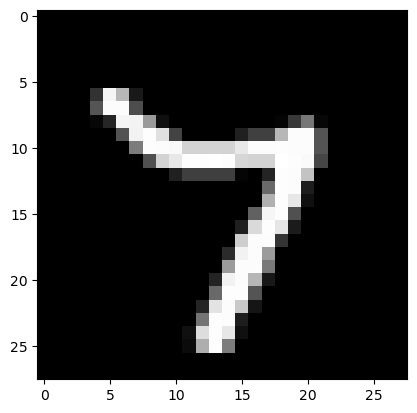

Prediction: [7]
Label: 7


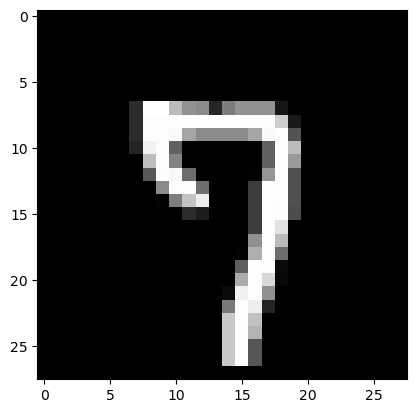

Prediction: [7]
Label: 7


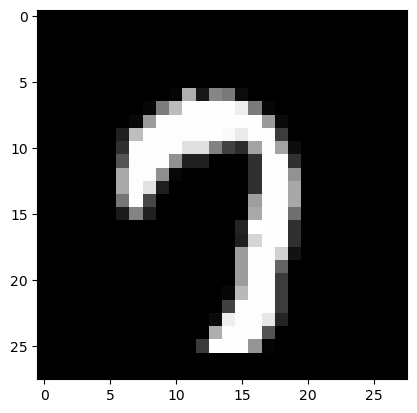

Prediction: [3]
Label: 3


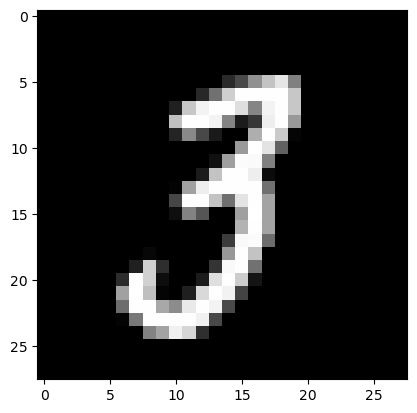

Prediction: [1]
Label: 1


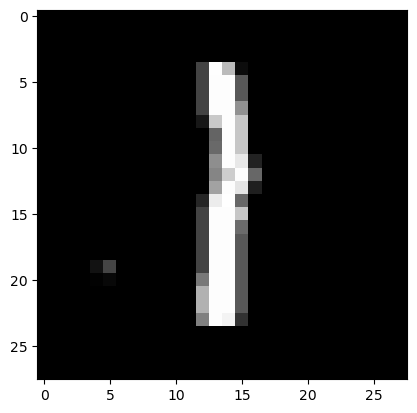

In [14]:
import random

for i in range(10):
    idx = random.randint(0, len(data_train))
    test_prediction(X_train, Y_train, idx, W1, b1, W2, b2)

### **See The Training Graph**

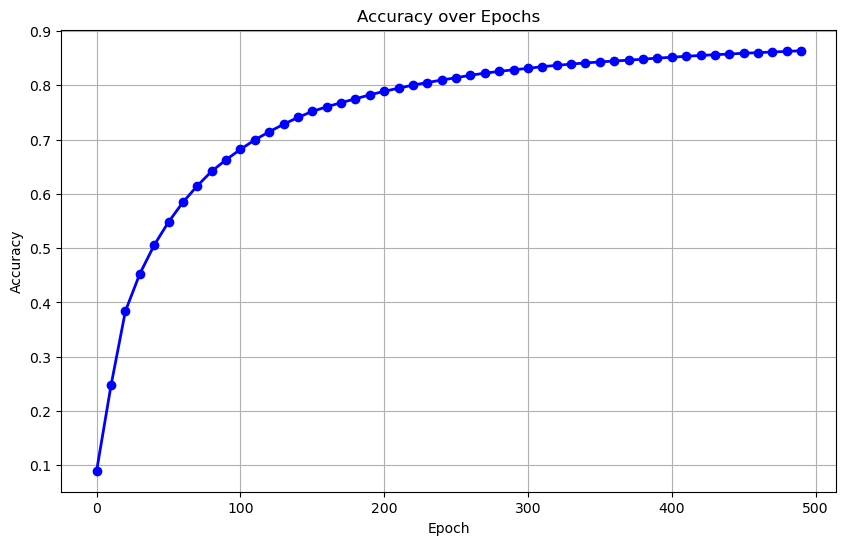

In [17]:
epochs = list(accuracy_dict.keys())
# print(epochs)
accuracies = list(accuracy_dict.values())
# accuracies = list(float(f'{(accuracy_dict.values()):.3f}'))

plt.figure(figsize=(10, 6))
plt.plot(epochs, accuracies, marker='o', color='b', linestyle='-', linewidth=2, markersize=6)

plt.yticks([0.1 * i for i in range(1, 10)])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.grid(True)
plt.show()